In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import codecs
import os
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
import torch as tf
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
%matplotlib inline
import numpy as np
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

CUDA = tf.cuda.is_available()
DEVICE=tf.device('cuda:0')

./data/fasttext-wikinews/wiki-news-300d-1M.vec
./data/preprocessed/train_df.csv
./data/preprocessed/bibles_suffled.csv
./data/preprocessed/newbible.tsv
./data/preprocessed/oldbible.tsv
./data/preprocessed/test_df.csv
./data/preprocessed/val_df.csv


In [7]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)

In [8]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [9]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

        return output, final

In [10]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
                 
        # to initialize from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""
                                         
        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)
        
        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)
        
        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []
        
        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]

    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))       

In [11]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        # to store attention scores
        self.alphas = None
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)
        
        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)
        
        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas

In [12]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model

In [13]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()

In [14]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))

In [15]:
def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
        if(i % 2 == 0):
            continue
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (count+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        count += 1
        if count == n:
            break

In [16]:
def data_gen(num_words=11, batch_size=16, num_batches=100, length=10, pad_index=0, sos_index=1):
    """Generate random data for a src-tgt copy task."""
    for i in range(num_batches):
        data = torch.from_numpy(
          np.random.randint(1, num_words, size=(batch_size, length)))
        data[:, 0] = sos_index
        data = data.cuda() if USE_CUDA else data
        src = data[:, 1:]
        trg = data
        src_lengths = [length-1] * batch_size
        trg_lengths = [length] * batch_size
        yield Batch((src, src_lengths), (trg, trg_lengths), pad_index=pad_index)

In [17]:
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

In [18]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    # cut off everything starting from </s> 
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)
  

def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [19]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)


In [20]:
from torchtext import data, datasets
import en_core_web_sm
en = en_core_web_sm.load()

In [21]:
import spacy
spacy_en = spacy.load('en_core_web_sm')

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"    
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
LOWER = True

# we include lengths to provide to the RNNs
SRC = data.Field(tokenize=tokenize_en, 
                 batch_first=True, lower=LOWER, include_lengths=True,
                 unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)

TRG = data.Field(tokenize=tokenize_en, 
                 batch_first=True, lower=LOWER, include_lengths=True,
                 unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

MAX_LEN_SRC = 50 
MAX_LEN_TRG = 50  

fields = [
    ('ID', None), # we dont need this, so no processing
    ('src', SRC), # process it as label
    ('trg', TRG) # process it as text
]


train_data, valid_data, test_data = data.TabularDataset.splits(path='./data/preprocessed/',train='train_df.csv',
                                    validation='val_df.csv', test='test_df.csv', format='csv',
                                    fields=fields,
                                    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN_SRC 
                                    and len(vars(x)['trg']) <= MAX_LEN_TRG)

MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed

SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)
PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]

In [22]:
def print_data_info(train_data, valid_data, test_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    print("trg:", " ".join(vars(train_data[0])['trg']), "\n")
    
    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of text words (types):", len(src_field.vocab))
    print("Number of title words (types):", len(trg_field.vocab), "\n")
    
    
print_data_info(train_data, valid_data, test_data,   SRC, TRG)

Data set sizes (number of sentence pairs):
train 21149
valid 6064
test 3036 

First training example:
src: then from before him sent is the extremity of the hand and the writing is noted down
trg: then was the part of the hand sent from before him and this writing was inscribed 

Most common words (src):
       and      38562
       the      36059
        of      24000
        to      14279
        in       9511
        is       8165
        he       6509
       for       6007
       his       5481
      hath       5432 

Most common words (trg):
       the      37554
       and      23022
        of      22092
        to      13885
       you      10015
        in       8335
        he       6941
       for       5953
      that       5573
       his       5361 

First 10 words (src):
00 <unk>
01 <pad>
02 </s>
03 and
04 the
05 of
06 to
07 in
08 is
09 he 

First 10 words (trg):
00 <unk>
01 <pad>
02 <s>
03 </s>
04 the
05 and
06 of
07 to
08 you
09 in 

Number of text words (types): 4306


In [23]:
batch_size = 36

In [24]:
train_iter = data.BucketIterator(train_data, batch_size=batch_size, train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)

In [25]:
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)

In [26]:
def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

In [27]:
def train(model, num_epochs=50, lr=0.0003, print_every=100):
    """Train a model on IWSLT"""
    
    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        torch.save(model.state_dict(), 'model_epoch_' + str(epoch))

        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
    torch.save(model.state_dict(), 'model_Final')

    return dev_perplexities

In [28]:
USE_CUDA = True

In [29]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=3, dropout=0.2)

dev_perplexities = train(model,num_epochs=10, print_every=100)
model.load_state_dict(torch.load('model_epoch_30'))
model.eval()

Epoch 0
Epoch Step: 100 Loss: 80.977150 Tokens per Sec: 7832.301123
Epoch Step: 200 Loss: 175.746643 Tokens per Sec: 8195.350608
Epoch Step: 300 Loss: 80.492233 Tokens per Sec: 8064.037693
Epoch Step: 400 Loss: 152.455582 Tokens per Sec: 8074.161294
Epoch Step: 500 Loss: 69.069016 Tokens per Sec: 7746.044165

Example #1
Src :  yea he putteth his life in his hand and smiteth the philistine and jehovah worketh great salvation for all israel thou hast seen and dost rejoice and why dost thou sin against innocent blood to put david to death for nought
Trg :  for he put his life in his hand and struck the philistine and yahweh worked great victory for all israel you saw it and did rejoice why then will you sin against innocent blood to kill david without cause
Pred:  he has his father in his hand and his hand and all the land and the land and all the land and all the land of israel and you have spoken to the land

Example #2
Src :  take therefore from him the talent and give to him having th

Example #2
Src :  take therefore from him the talent and give to him having the ten talents
Trg :  take away therefore the talent from him and give it to him who has the ten talents
Pred:  take him from him the baals and gave him the ten talents

Example #3
Src :  who not of blood nor of will of flesh nor of will of man but of god were begotten
Trg :  who were born not of blood nor of the will of the flesh nor of the will of man but of god
Pred:  who doesn not be blood of the shadow of flesh neither of the flesh of the god of god and of god

Validation perplexity: 11.710562
Epoch 6
Epoch Step: 100 Loss: 64.129440 Tokens per Sec: 7217.277562
Epoch Step: 200 Loss: 37.448990 Tokens per Sec: 8522.761018
Epoch Step: 300 Loss: 32.447514 Tokens per Sec: 9167.261786
Epoch Step: 400 Loss: 56.850044 Tokens per Sec: 7081.775866
Epoch Step: 500 Loss: 37.537956 Tokens per Sec: 8029.686449

Example #1
Src :  yea he putteth his life in his hand and smiteth the philistine and jehovah worketh great sal

EncoderDecoder(
  (encoder): Encoder(
    (rnn): GRU(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (key_layer): Linear(in_features=512, out_features=256, bias=False)
      (query_layer): Linear(in_features=256, out_features=256, bias=False)
      (energy_layer): Linear(in_features=256, out_features=1, bias=False)
    )
    (rnn): GRU(768, 256, num_layers=3, batch_first=True, dropout=0.2)
    (bridge): Linear(in_features=512, out_features=256, bias=True)
    (dropout_layer): Dropout(p=0.2, inplace=False)
    (pre_output_layer): Linear(in_features=1024, out_features=256, bias=False)
  )
  (src_embed): Embedding(4306, 256)
  (trg_embed): Embedding(4351, 256)
  (generator): Generator(
    (proj): Linear(in_features=256, out_features=4351, bias=False)
  )
)

In [33]:
def train_from_epoch(model, num_epochs=50, lr=0.0003, print_every=100, epoch_start=0):
    """Train a model on IWSLT"""
    
    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch+epoch_start)
        torch.save(model.state_dict(), 'model_epoch_' + str(epoch+epoch_start))

        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
    torch.save(model.state_dict(), 'model_Final')

    return dev_perplexities

In [34]:
model.load_state_dict(torch.load('model_epoch_9'))
dev_perplexities = train_from_epoch(model,num_epochs=10, print_every=100, epoch_start=10)
model.eval()

Epoch 10
Epoch Step: 100 Loss: 35.821331 Tokens per Sec: 7009.113167
Epoch Step: 200 Loss: 25.276556 Tokens per Sec: 6594.874926
Epoch Step: 300 Loss: 26.259104 Tokens per Sec: 6542.735970
Epoch Step: 400 Loss: 52.920311 Tokens per Sec: 6356.165963
Epoch Step: 500 Loss: 35.956310 Tokens per Sec: 6603.157095

Example #1
Src :  yea he putteth his life in his hand and smiteth the philistine and jehovah worketh great salvation for all israel thou hast seen and dost rejoice and why dost thou sin against innocent blood to put david to death for nought
Trg :  for he put his life in his hand and struck the philistine and yahweh worked great victory for all israel you saw it and did rejoice why then will you sin against innocent blood to kill david without cause
Pred:  he put his life in his hand and struck the philistine and yahweh gave great salvation for all israel you have seen and do you why do you sin against innocent blood to death to death

Example #2
Src :  take therefore from him the 

Example #2
Src :  take therefore from him the talent and give to him having the ten talents
Trg :  take away therefore the talent from him and give it to him who has the ten talents
Pred:  take therefore from him the one and gave him <unk> and ten ten talents

Example #3
Src :  who not of blood nor of will of flesh nor of will of man but of god were begotten
Trg :  who were born not of blood nor of the will of the flesh nor of the will of man but of god
Pred:  who doesn of the thirsty nor of the flesh of the flesh neither of the flesh of man but of god are born

Validation perplexity: 8.038753
Epoch 16
Epoch Step: 100 Loss: 14.420735 Tokens per Sec: 7370.892460
Epoch Step: 200 Loss: 19.995144 Tokens per Sec: 7054.755297
Epoch Step: 300 Loss: 44.234028 Tokens per Sec: 7409.444975
Epoch Step: 400 Loss: 25.044319 Tokens per Sec: 7572.283551
Epoch Step: 500 Loss: 45.787323 Tokens per Sec: 8184.837924

Example #1
Src :  yea he putteth his life in his hand and smiteth the philistine and jeho

EncoderDecoder(
  (encoder): Encoder(
    (rnn): GRU(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (key_layer): Linear(in_features=512, out_features=256, bias=False)
      (query_layer): Linear(in_features=256, out_features=256, bias=False)
      (energy_layer): Linear(in_features=256, out_features=1, bias=False)
    )
    (rnn): GRU(768, 256, num_layers=3, batch_first=True, dropout=0.2)
    (bridge): Linear(in_features=512, out_features=256, bias=True)
    (dropout_layer): Dropout(p=0.2, inplace=False)
    (pre_output_layer): Linear(in_features=1024, out_features=256, bias=False)
  )
  (src_embed): Embedding(4306, 256)
  (trg_embed): Embedding(4351, 256)
  (generator): Generator(
    (proj): Linear(in_features=256, out_features=4351, bias=False)
  )
)

In [37]:
dev_perplexities = []

In [39]:
dev_perplexities = []
criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
for i in range(0,19) :
    model.load_state_dict(torch.load('model_epoch_' + str(i)))
    model.eval()

    with torch.no_grad():       

        dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                   model, 
                                   SimpleLossCompute(model.generator, criterion, None),print_every=100)
        print("Validation perplexity epoch " + str(i) + " : %f" % dev_perplexity)
        dev_perplexities.append(dev_perplexity)

Validation perplexity epoch 0 : 4411.843900
Validation perplexity epoch 1 : 61.483501
Validation perplexity epoch 2 : 28.813935
Validation perplexity epoch 3 : 17.245197
Validation perplexity epoch 4 : 13.348745
Validation perplexity epoch 5 : 11.266227
Validation perplexity epoch 6 : 11.710562
Validation perplexity epoch 7 : 9.297739
Validation perplexity epoch 8 : 8.891163
Validation perplexity epoch 9 : 9.080273
Validation perplexity epoch 10 : 9.080273
Validation perplexity epoch 11 : 8.112408
Validation perplexity epoch 12 : 8.149577
Validation perplexity epoch 13 : 8.029802
Validation perplexity epoch 14 : 7.950835
Validation perplexity epoch 15 : 8.048833
Validation perplexity epoch 16 : 8.038753
Validation perplexity epoch 17 : 8.205517
Validation perplexity epoch 18 : 8.837982


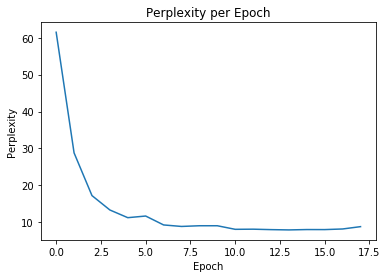

In [41]:
plot_perplexity(dev_perplexities[1:])

In [43]:
model.load_state_dict(torch.load('model_epoch_14'))
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (rnn): GRU(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (key_layer): Linear(in_features=512, out_features=256, bias=False)
      (query_layer): Linear(in_features=256, out_features=256, bias=False)
      (energy_layer): Linear(in_features=256, out_features=1, bias=False)
    )
    (rnn): GRU(768, 256, num_layers=3, batch_first=True, dropout=0.2)
    (bridge): Linear(in_features=512, out_features=256, bias=True)
    (dropout_layer): Dropout(p=0.2, inplace=False)
    (pre_output_layer): Linear(in_features=1024, out_features=256, bias=False)
  )
  (src_embed): Embedding(4306, 256)
  (trg_embed): Embedding(4351, 256)
  (generator): Generator(
    (proj): Linear(in_features=256, out_features=4351, bias=False)
  )
)

In [44]:
test_iter = data.Iterator(test_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)

In [45]:
print_examples((rebatch(PAD_INDEX, x) for x in test_iter), 
               model, n=10, src_vocab=SRC.vocab, trg_vocab=TRG.vocab) 


Example #1
Src :  hollow with boards thou dost make it as it hath been shewed thee in the mount so do they make it
Trg :  hollow with <unk> shall you make it as it has been shown you on the mountain so shall they make it
Pred:  will make it hollow with boards with boards as it is exalted you shall make you in the mountain so shall they make it

Example #2
Src :  and also have heard the groaning of the sons of israel whom the egyptians are causing to serve and remember my covenant
Trg :  moreover have heard the groaning of the children of israel whom the egyptians keep in bondage and have remembered my covenant
Pred:  also heard the pride of the children of israel whom the egyptians worship them and remember my covenant

Example #3
Src :  and he doth the evil thing in the eyes of jehovah according to all that jehoiakim hath done
Trg :  he did that which was evil in the sight of yahweh according to all that jehoiakim had done
Pred:  he did that which was evil in the sight of yahweh acco